# Preamble

In [64]:
from __future__ import division
import tensorflow as tf
import numpy as np
import tarfile
import os
import matplotlib.pyplot as plt
import time
%matplotlib inline

# Import Data

In [65]:
def csv_to_numpy_array(filePath, delimiter):
    return np.genfromtxt(filePath, delimiter=delimiter, dtype=None)

def import_data():
    if "data" not in os.listdir(os.getcwd()):
        # Untar directory of data if we haven't already
        tarObject = tarfile.open("data.tar.gz")
        tarObject.extractall()
        tarObject.close()
        print("Extracted tar to current directory")
    else:
        # we've already extracted the files
        pass

    print("loading training data")
    trainX = csv_to_numpy_array("data/trainX.csv", delimiter="\t")
    trainY = csv_to_numpy_array("data/trainY.csv", delimiter="\t")
    print("loading test data")
    testX = csv_to_numpy_array("data/testX.csv", delimiter="\t")
    testY = csv_to_numpy_array("data/testY.csv", delimiter="\t")
    return trainX,trainY,testX,testY

trainX,trainY,testX,testY = import_data()

loading training data
loading test data


# Global Parameters

In [66]:
# DATA SET PARAMETERS
# Get our dimensions for our different variables and placeholders:
# numFeatures = the number of words extracted from each email
numFeatures = trainX.shape[1]
# numLabels = number of classes we are predicting (here just 2: Ham or Spam)
numLabels = trainY.shape[1]
numHidden = 8
# TRAINING SESSION PARAMETERS
# number of times we iterate through training data
# tensorboard shows that accuracy plateaus at ~25k epochs
numEpochs = 27000
# a smarter learning rate for gradientOptimizer
learningRate = tf.train.exponential_decay(learning_rate=0.0008,
                                          global_step= 1,
                                          decay_steps=trainX.shape[0],
                                          decay_rate= 0.95,
                                          staircase=True)

# Placeholders Logistic Regression

In [67]:
# X = X-matrix / feature-matrix / data-matrix... It's a tensor to hold our email
# data. 'None' here means that we can hold any number of emails
X = tf.placeholder(tf.float32, [None, numFeatures])
# yGold = Y-matrix / label-matrix / labels... This will be our correct answers
# matrix. Every row has either [1,0] for SPAM or [0,1] for HAM. 'None' here 
# means that we can hold any number of emails
yGold = tf.placeholder(tf.float32, [None, numLabels])

# Placeholders Neural Network

In [68]:
# X = X-matrix / feature-matrix / data-matrix... It's a tensor to hold our email
# data. 'None' here means that we can hold any number of emails
Xnn = tf.placeholder(tf.float32, [None, numFeatures])
# yGold = Y-matrix / label-matrix / labels... This will be our correct answers
# matrix. Every row has either [1,0] for SPAM or [0,1] for HAM. 'None' here 
# means that we can hold any number of emails
yGoldnn = tf.placeholder(tf.float32, [None, numLabels])

# Variables Logistic Regression

In [69]:
# Values are randomly sampled from a Gaussian with a standard deviation of:
#     sqrt(6 / (numInputNodes + numOutputNodes + 1))

weights = tf.Variable(tf.random_normal([numFeatures,numLabels],
                                       mean=0,
                                       stddev=(np.sqrt(6/numFeatures+
                                                         numLabels+1)),
                                       name="weights"))

bias = tf.Variable(tf.random_normal([1,numLabels],
                                    mean=0,
                                    stddev=(np.sqrt(6/numFeatures+numLabels+1)),
                                    name="bias"))

# Variables Neural Network

In [70]:
# Values are randomly sampled from a Gaussian with a standard deviation of:
#     sqrt(6 / (numInputNodes + numOutputNodes + 1))

weights_1_2nn = tf.Variable(tf.random_normal([numFeatures,numHidden],
                                       mean=0,
                                       stddev=(np.sqrt(6/numFeatures+
                                                         numHidden+1)),
                                       name="weights_1_2"))

bias_hiddennn = tf.Variable(tf.random_normal([1,numHidden],
                                    mean=0,
                                    stddev=(np.sqrt(6/numFeatures+numLabels+1)),
                                    name="bias_hidden"))

weights_2_3nn = tf.Variable(tf.random_normal([numHidden,numLabels],
                                       mean=0,
                                       stddev=(np.sqrt(6/numHidden+
                                                         numLabels+1)),
                                       name="weights_2_3"))

bias_outnn = tf.Variable(tf.random_normal([1,numLabels],
                                    mean=0,
                                    stddev=(np.sqrt(6/numFeatures+numLabels+1)),
                                    name="bias_out"))


# Prediction Ops Logistic Regression

In [71]:
# INITIALIZE our weights and biases
init_OP = tf.initialize_all_variables()

# PREDICTION ALGORITHM i.e. FEEDFORWARD ALGORITHM
apply_weights_OP = tf.matmul(X, weights, name="apply_weights")
add_bias_OP = tf.add(apply_weights_OP, bias, name="add_bias") 
activation_OP = tf.nn.sigmoid(add_bias_OP, name="activation")

# Prediction Ops Neural Network

In [72]:
# INITIALIZE our weights and biases
init_OPnn = tf.initialize_all_variables()

# Neural Network

apply_weights_1nn = tf.matmul(Xnn, weights_1_2nn, name="apply_weightsnn")
add_bias_1nn = tf.add(apply_weights_1nn, bias_hiddennn, name="add_biasnn") 
activation_1nn = tf.nn.sigmoid(add_bias_1nn, name="activationnn")

apply_weights_OPnn = tf.matmul(activation_1nn, weights_2_3nn, name="apply_weights2nn")
add_bias_OPnn = tf.add(apply_weights_OPnn, bias_outnn, name="add_bias2nn") 
activation_OPnn = tf.nn.sigmoid(add_bias_OPnn, name="activation2nn")

# Evaluation Ops Logistic Regression

In [73]:
cost_OP = tf.nn.l2_loss(activation_OP-yGold, name="squared_error_cost")

# Evaluation Ops Neural Network

In [74]:
cost_OPnn = tf.nn.l2_loss(activation_OPnn-yGoldnn, name="squared_error_costnn")

# Optimization Op Logistic Regression

In [75]:
# OPTIMIZATION ALGORITHM i.e. GRADIENT DESCENT
training_OP = tf.train.GradientDescentOptimizer(learningRate).minimize(cost_OP)

# Optimization Op Neural Network

In [76]:
# OPTIMIZATION ALGORITHM i.e. GRADIENT DESCENT
training_OPnn = tf.train.GradientDescentOptimizer(learningRate).minimize(cost_OPnn)

# Graphing Variables Logistic Regression

In [77]:
epoch_values=[]
accuracy_values=[]
cost_values=[]


# Graphing Variables Neural Network

In [78]:
epoch_valuesnn=[]
accuracy_valuesnn=[]
cost_valuesnn=[]

# Run the Training  Logistic Regression

In [79]:
# Create a tensorflow session
sess = tf.Session()

# Initialize all tensorflow variables
sess.run(init_OP)

## Ops for vizualization
# argmax(activation_OP, 1) gives the label our model thought was most likely
# argmax(yGold, 1) is the correct label
correct_predictions_OP = tf.equal(tf.argmax(activation_OP,1),tf.argmax(yGold,1))
# False is 0 and True is 1, what was our average?
accuracy_OP = tf.reduce_mean(tf.cast(correct_predictions_OP, "float"))
# Summary op for regression output
activation_summary_OP = tf.histogram_summary("output", activation_OP)
# Summary op for accuracy
accuracy_summary_OP = tf.scalar_summary("accuracy", accuracy_OP)
# Summary op for cost
cost_summary_OP = tf.scalar_summary("cost", cost_OP)
# Summary ops to check how variables (W, b) are updating after each iteration
weightSummary = tf.histogram_summary("weights", weights.eval(session=sess))
biasSummary = tf.histogram_summary("biases", bias.eval(session=sess))
# Merge all summaries
all_summary_OPS = tf.merge_all_summaries()
# Summary writer
writer = tf.train.SummaryWriter("summary_logs", sess.graph_def)

# Initialize reporting variables
cost = 0
diff = 1

# Training epochs
for i in range(numEpochs):
    if i > 1 and diff < .0001:
        print("change in cost %g; convergence."%diff)
        break
    else:
        # Run training step
        step = sess.run(training_OP, feed_dict={X: trainX, yGold: trainY})
        # Report occasional stats
        if i % 10 == 0:
            # Add epoch to epoch_values
            epoch_values.append(i)
            # Generate accuracy stats on test data
            train_accuracy, newCost = sess.run(
                [accuracy_OP, cost_OP], 
                feed_dict={X: trainX, yGold: trainY}
            )
            # Add accuracy to live graphing variable
            accuracy_values.append(train_accuracy)
            # Add cost to live graphing variable
            cost_values.append(newCost)
            # Write summary stats to writer
            #writer.add_summary(summary_results, i)
            # Re-assign values for variables
            diff = abs(newCost - cost)
            cost = newCost

            #generate print statements
            print("step %d, training accuracy %g"%(i, train_accuracy))
            print("step %d, cost %g"%(i, newCost))
            print("step %d, change in cost %g"%(i, diff))

            
            time.sleep(1)


# How well do we perform on held-out test data?
print("final accuracy on test set: %s" %str(sess.run(accuracy_OP, 
                                                     feed_dict={X: testX, 
                                                                yGold: testY})))

step 0, training accuracy 0.469045
step 0, cost 257.529
step 0, change in cost 257.529
step 10, training accuracy 0.528856
step 10, cost 244.603
step 10, change in cost 12.9261
step 20, training accuracy 0.56978
step 20, cost 238.027
step 20, change in cost 6.57657
step 30, training accuracy 0.567681
step 30, cost 235.182
step 30, change in cost 2.84454
step 40, training accuracy 0.571878
step 40, cost 234.008
step 40, change in cost 1.17383
step 50, training accuracy 0.575026
step 50, cost 233.506
step 50, change in cost 0.502197
step 60, training accuracy 0.582371
step 60, cost 233.265
step 60, change in cost 0.241333
step 70, training accuracy 0.582371
step 70, cost 233.124
step 70, change in cost 0.14093
step 80, training accuracy 0.582371
step 80, cost 233.022
step 80, change in cost 0.102066
step 90, training accuracy 0.579224
step 90, cost 232.934
step 90, change in cost 0.0872955
step 100, training accuracy 0.580273
step 100, cost 232.853
step 100, change in cost 0.0814209
step

# Training Ops Neural Network

In [80]:
# Create a tensorflow session
sess = tf.Session()

# Initialize all tensorflow variables
sess.run(init_OP)

## Ops for vizualization
# argmax(activation_OP, 1) gives the label our model thought was most likely
# argmax(yGold, 1) is the correct label
correct_predictions_OPnn = tf.equal(tf.argmax(activation_OPnn,1),tf.argmax(yGoldnn,1))
# False is 0 and True is 1, what was our average?
accuracy_OPnn = tf.reduce_mean(tf.cast(correct_predictions_OPnn, "float"))


# Initialize reporting variables
cost = 0
diff = 1

# Training epochs
for i in range(numEpochs):
    if i > 1 and diff < .0001:
        print("change in cost %g; convergence."%diff)
        break
    else:
        # Run training step
        step = sess.run(training_OPnn, feed_dict={Xnn: trainX, yGoldnn: trainY})
        # Report occasional stats
        if i % 10 == 0:
            # Add epoch to epoch_values
            epoch_valuesnn.append(i)
            # Generate accuracy stats on test data
            train_accuracy, newCost = sess.run(
                [accuracy_OPnn, cost_OPnn], 
                feed_dict={Xnn: trainX, yGoldnn: trainY}
            )
            # Add accuracy to live graphing variable
            accuracy_valuesnn.append(train_accuracy)
            # Add cost to live graphing variable
            cost_valuesnn.append(newCost)
            # Write summary stats to writer
            #writer.add_summary(summary_results, i)
            # Re-assign values for variables
            diff = abs(newCost - cost)
            cost = newCost

            #generate print statements
            print("step %d, training accuracy %g"%(i, train_accuracy))
            print("step %d, cost %g"%(i, newCost))
            print("step %d, change in cost %g"%(i, diff))

           
            time.sleep(1)


# How well do we perform on held-out test data?
print("final accuracy on test set: %s" %str(sess.run(accuracy_OPnn, 
                                                     feed_dict={Xnn: testX, 
                                                                yGoldnn: testY})))

step 0, training accuracy 0.466946
step 0, cost 463.352
step 0, change in cost 463.352
step 10, training accuracy 0.466946
step 10, cost 452.735
step 10, change in cost 10.6168
step 20, training accuracy 0.466946
step 20, cost 413.871
step 20, change in cost 38.8636
step 30, training accuracy 0.466946
step 30, cost 370.842
step 30, change in cost 43.0297
step 40, training accuracy 0.466946
step 40, cost 369.716
step 40, change in cost 1.12534
step 50, training accuracy 0.466946
step 50, cost 369.591
step 50, change in cost 0.125549
step 60, training accuracy 0.466946
step 60, cost 369.463
step 60, change in cost 0.127716
step 70, training accuracy 0.466946
step 70, cost 369.328
step 70, change in cost 0.134888
step 80, training accuracy 0.466946
step 80, cost 369.185
step 80, change in cost 0.143768
step 90, training accuracy 0.466946
step 90, cost 369.03
step 90, change in cost 0.154388
step 100, training accuracy 0.466946
step 100, cost 368.862
step 100, change in cost 0.168091
step 

# Graph Live Updating

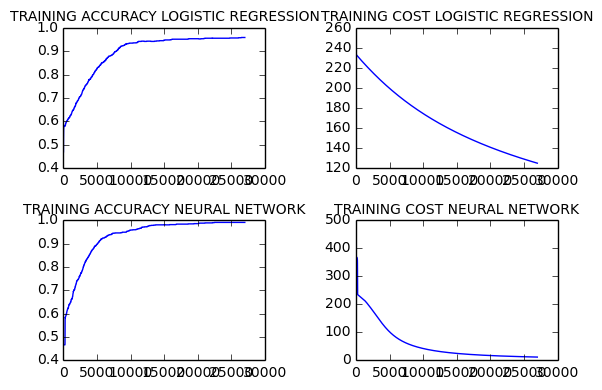

In [81]:
# Turn on interactive plotting
plt.ion()
# Create the main, super plot
fig = plt.figure()
# Create two subplots on their own axes and give titles
ax1 = plt.subplot("221")
ax1.set_title("TRAINING ACCURACY LOGISTIC REGRESSION", fontsize=10)
ax2 = plt.subplot("222")
ax2.set_title("TRAINING COST LOGISTIC REGRESSION", fontsize=10)

ax3 = plt.subplot("223")
ax3.set_title("TRAINING ACCURACY NEURAL NETWORK", fontsize=10)
ax4 = plt.subplot("224")
ax4.set_title("TRAINING COST NEURAL NETWORK", fontsize=10)

plt.tight_layout()

# Plot progress to our two subplots
accuracyLine, = ax1.plot(epoch_values, accuracy_values)
costLine, = ax2.plot(epoch_values, cost_values)
accuracyLinenn, = ax3.plot(epoch_valuesnn, accuracy_valuesnn)
costLinenn, = ax4.plot(epoch_valuesnn, cost_valuesnn)
fig.canvas.draw()